In [2]:
import sys
sys.path.insert(1, '../src/')
import config
import pandas as pd

Let's take a quick look at the data

In [28]:
df = pd.read_csv(config.RETAIL_FILE)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Mostly everythig in the raw form is observed and except for the customer ID. We'll look what it looks like and whether they can be inferred?(for example if we see a similar invoice number ).

In [12]:
from collections import Counter
# Most common country is UK by far it even dwarves the second country.
Counter(df['Country'])

Counter({'United Kingdom': 495478,
         'France': 8557,
         'Australia': 1259,
         'Netherlands': 2371,
         'Germany': 9495,
         'Norway': 1086,
         'EIRE': 8196,
         'Switzerland': 2002,
         'Spain': 2533,
         'Poland': 341,
         'Portugal': 1519,
         'Italy': 803,
         'Belgium': 2069,
         'Lithuania': 35,
         'Japan': 358,
         'Iceland': 182,
         'Channel Islands': 758,
         'Denmark': 389,
         'Cyprus': 622,
         'Sweden': 462,
         'Austria': 401,
         'Israel': 297,
         'Finland': 695,
         'Bahrain': 19,
         'Greece': 146,
         'Hong Kong': 288,
         'Singapore': 229,
         'Lebanon': 45,
         'United Arab Emirates': 68,
         'Saudi Arabia': 10,
         'Czech Republic': 30,
         'Canada': 151,
         'Unspecified': 446,
         'Brazil': 32,
         'USA': 291,
         'European Community': 61,
         'Malta': 127,
         'RSA': 58})

Customer id might be a number but the number is just an identifier, so it should not be float let's make it a string(or int)


In [18]:
import numpy as np

In [32]:
# df.loc[:,'CustomerID'] = 
df.loc[:,'customer_id'] = df['CustomerID'].apply(lambda x: str(np.int(x)) if pd.notna(x) else np.nan)

The date column also needs to be formatted as a date.

In [33]:
import datetime
df.loc[:,'date'] = df['InvoiceDate'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y %H:%M'))
#or just
#pd.to_datetime(df['InvoiceDate'])

In [35]:
# take a look at missing customers, and whether we can do any imputations
df.loc[pd.isna(df['customer_id'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,customer_id
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom,2010-12-01 11:52:00,NaN
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom,2010-12-01 14:32:00,NaN
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom,2010-12-01 14:32:00,NaN
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom,2010-12-01 14:32:00,NaN
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom,2010-12-01 14:32:00,NaN
...,...,...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom,2011-12-09 10:26:00,NaN
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom,2011-12-09 10:26:00,NaN
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom,2011-12-09 10:26:00,NaN
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom,2011-12-09 10:26:00,NaN


We see quite some things that we have to decide how we want to process them for example:
- StockCode: DOT
- empty description

Let's see if people with a missing customer id also appear with other customer ids' but same invoice number

In [42]:
unique_invoiced_missing_customers = df.loc[pd.isna(df['customer_id'])]['InvoiceNo'].unique()
df.loc[(df['InvoiceNo'].isin(unique_invoiced_missing_customers)) & (pd.notna(df['customer_id']))]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,customer_id


No! nothing we can do with guesing who they are.

But given this data what is it that matters for a company in terms of monitoring their metrics?

A good starting point is with the *monetary revenues* over a period of time.

Take monthly revenues:

In [54]:
# first sort df by date
df = df.sort_values(by='date')
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,17850
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850
...,...,...,...,...,...,...,...,...,...,...
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09 12:50:00,12680
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,2011-12-09 12:50:00,12680
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,12/9/2011 12:50,3.75,12680.0,France,2011-12-09 12:50:00,12680
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,12/9/2011 12:50,1.95,12680.0,France,2011-12-09 12:50:00,12680


In [56]:
df.loc[:,'revenue'] = df['UnitPrice']*df['Quantity']
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,customer_id,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010-12-01 08:26:00,17850,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010-12-01 08:26:00,17850,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010-12-01 08:26:00,17850,20.34
...,...,...,...,...,...,...,...,...,...,...,...
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,2011-12-09 12:50:00,12680,16.60
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,2011-12-09 12:50:00,12680,10.20
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,12/9/2011 12:50,3.75,12680.0,France,2011-12-09 12:50:00,12680,15.00
541894,581587,22631,CIRCUS PARADE LUNCH BOX,12,12/9/2011 12:50,1.95,12680.0,France,2011-12-09 12:50:00,12680,23.40


In [75]:
monthly_revenues = df.resample('MS', on='date')['revenue'].agg('sum').reset_index() # MS=Month start
monthly_revenues.rename(columns = {'date':'year_month'}, inplace=True)


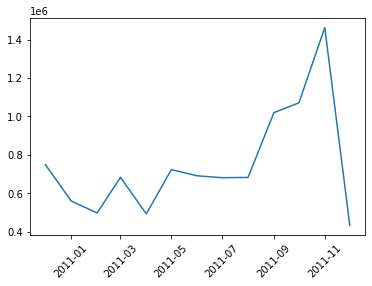

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

`Plotly` is very good for *interactive* plots.
- It provides seamless web hosting capabilities for your graphs. 
- if needed you can definitely use Plotly entirely offline, rendering interactive plots directly inside a notebook plus capabilities to export them to (still interactive) HTML files.


In [80]:
!pip install plotly
!pip install cufflinks

     |████████████████████████████████| 13.2 MB 11.3 MB/s 
  Using cached retrying-1.3.3-py3-none-any.whl
     |████████████████████████████████| 81 kB 5.8 MB/s 
  Using cached ipywidgets-7.6.3-py2.py3-none-any.whl (121 kB)
  Using cached widgetsnbextension-3.5.1-py2.py3-none-any.whl (2.2 MB)
  Using cached nbformat-5.1.2-py3-none-any.whl (113 kB)
  Using cached jupyterlab_widgets-1.0.0-py3-none-any.whl (243 kB)
  Using cached jsonschema-3.2.0-py2.py3-none-any.whl (56 kB)
  Using cached attrs-20.3.0-py2.py3-none-any.whl (49 kB)
  Using cached pyrsistent-0.17.3-cp38-cp38-linux_x86_64.whl
  Using cached notebook-6.2.0-py3-none-any.whl (9.5 MB)
  Using cached argon2_cffi-20.1.0-cp35-abi3-manylinux1_x86_64.whl (97 kB)
  Using cached terminado-0.9.2-py3-none-any.whl (14 kB)
  Using cached nbconvert-6.0.7-py3-none-any.whl (552 kB)
  Using cached Send2Trash-1.5.0-py3-none-any.whl (12 kB)
  Using cached prometheus_client-0.9.0-py2.py3-none-any.whl (53 kB)
  Using cached cffi-1.14.5-cp38-cp38-m

In [81]:
!pip install ipywidgets

In [82]:
!jupyter nbextension enable --py widgetsnbextension

WebIO config in ~/.jupyter/jupyter_notebook_config.py but WebIO plugin not found
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


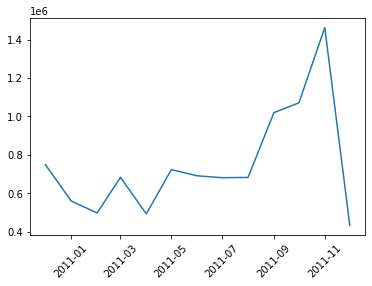

In [83]:
plt.figure()
plt.plot(monthly_revenues['year_month'], monthly_revenues['revenue'])
plt.xticks(rotation=45);


In [87]:
import plotly.offline as pyoff
import plotly.graph_objs as go

go_plot = [
    go.Scatter(x = monthly_revenues['year_month'], y =monthly_revenues['revenue'])
]

go_layout = go.Layout(
    xaxis = {'type':'category'},
    title = 'Monthly Revenue'
)

fig = go.Figure(data = go_plot, layout = go_layout)

pyoff.iplot(fig)